First I decided to try a different gradient descent method namely - ADAM optimizer. I read the following paper: https://arxiv.org/pdf/1412.6980.pdf and discovered that it combines the benefits of two extensions of gradient descent - AdaGrad and RMSProp which both already perform better than regular stochastic gradient descent. Initially I thought of applying learning rate decay in pairing with Adam but I found out that the ADAM optimizer already does apply some form of decay and that learning rate decay does not work particulary well with it. 

So next I read a few papers including: http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer which convinced me that adding a dropout to the existing logistic regression model in Q2 might give an improvement.

In [2]:
"""
Simple logistic regression model to solve OCR task 
with MNIST in TensorFlow
MNIST dataset: yann.lecun.com/exdb/mnist/
"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import time

# Define paramaters for the model
learning_rate = 0.01
batch_size = 128
n_epochs = 10
DROPOUT = 0.75

# Step 1: Read in data
# using TF Learn's built in function to load MNIST data to the folder MNIST_data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)


# Step 2: create placeholders for features and labels
# each image in the MNIST data is of shape 28*28 = 784
# therefore, each image is represented with a 1x784 tensor
# there are 10 classes for each image, corresponding to digits 0 - 9. 
# each lable is one hot vector.
X = tf.placeholder(tf.float32, [batch_size, 784], name='X_placeholder') 
Y = tf.placeholder(tf.int32, [batch_size, 10], name='Y_placeholder')

#dropout = tf.placeholder(tf.float32, name='dropout') #added placeholder for dropout

# Step 3: create weights and bias
# w is initialized to random variables with mean of 0, stddev of 0.01
# b is initialized to 0
# shape of w depends on the dimension of X and Y so that Y = tf.matmul(X, w)
# shape of b depends on Y
w = tf.Variable(tf.random_normal(shape=[784, 10], stddev=0.01), name='weights')
b = tf.Variable(tf.zeros([1, 10]), name="bias")

# Step 4: build model
# the model that returns the logits.
# this logits will be later passed through softmax layer
# to get the probability distribution of possible label of the image
# DO NOT DO SOFTMAX HERE
logits = tf.matmul(X, w) + b 
    # apply dropout
#logits = tf.nn.dropout(logits, dropout, name='logit_dropout')


# Step 5: define loss function
# use cross entropy loss of the real labels with the softmax of logits
# use the method:
# tf.nn.softmax_cross_entropy_with_logits(logits, Y)
# then use tf.reduce_mean to get the mean loss of the batch

entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y, name='loss')
loss = tf.reduce_mean(entropy) # computes the mean over all the examples in the batch

# Step 6: define training op
# using gradient descent to minimize loss
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.Session() as sess:
    writer = tf.summary.FileWriter('./graphs/logistic_reg_adam', sess.graph) # to visualize using TensorBoard
    start_time = time.time()
    sess.run(tf.global_variables_initializer())	
    n_batches = int(mnist.train.num_examples/batch_size)
    for i in range(n_epochs): # train the model n_epochs times
        total_loss = 0

        for _ in range(n_batches):
            X_batch, Y_batch = mnist.train.next_batch(batch_size)
            _, loss_batch = sess.run([optimizer, loss], feed_dict={X: X_batch, Y:Y_batch})
            total_loss += loss_batch
        print('Average loss epoch {0}: {1}'.format(i, total_loss/n_batches))

    print('Total time: {0} seconds'.format(time.time() - start_time))
    print('Optimization Finished!') # should be around 0.35 after 25 epochs

    # test the model
    n_batches = int(mnist.test.num_examples/batch_size)
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = mnist.test.next_batch(batch_size)
        _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict={X: X_batch, Y:Y_batch})
        preds = tf.nn.softmax(logits_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32)) # need numpy.count_nonzero(boolarr) :(
        total_correct_preds += sess.run(accuracy)

    print('Accuracy {0}'.format(total_correct_preds/mnist.test.num_examples))
    writer.close()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Average loss epoch 0: 0.3694290117575572
Average loss epoch 1: 0.2940027995473577
Average loss epoch 2: 0.28625442794500255
Average loss epoch 3: 0.2805714821204161
Average loss epoch 4: 0.2733050552489874
Average loss epoch 5: 0.27337993287192636
Average loss epoch 6: 0.271167913881632
Average loss epoch 7: 0.2651257185495539
Average loss epoch 8: 0.2663134197532992
Average loss epoch 9: 0.2669349051751457
Total time: 25.237061977386475 seconds
Optimization Finished!
Accuracy 0.922


Just using the Adam Optimizer gave an improvement of 3% to Q2 already! Next, I tried to just add a dropout right after the logit calculation.

In [10]:
"""
Simple logistic regression model to solve OCR task 
with MNIST in TensorFlow
MNIST dataset: yann.lecun.com/exdb/mnist/
"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import time

# Define paramaters for the model
learning_rate = 0.01
batch_size = 128
n_epochs = 10
DROPOUT = 0.75

# Step 1: Read in data
# using TF Learn's built in function to load MNIST data to the folder MNIST_data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)


# Step 2: create placeholders for features and labels
# each image in the MNIST data is of shape 28*28 = 784
# therefore, each image is represented with a 1x784 tensor
# there are 10 classes for each image, corresponding to digits 0 - 9. 
# each lable is one hot vector.
X = tf.placeholder(tf.float32, [batch_size, 784], name='X_placeholder') 
Y = tf.placeholder(tf.int32, [batch_size, 10], name='Y_placeholder')

dropout = tf.placeholder(tf.float32, name='dropout') #added placeholder for dropout

# Step 3: create weights and bias
# w is initialized to random variables with mean of 0, stddev of 0.01
# b is initialized to 0
# shape of w depends on the dimension of X and Y so that Y = tf.matmul(X, w)
# shape of b depends on Y
w = tf.Variable(tf.random_normal(shape=[784, 10], stddev=0.01), name='weights')
b = tf.Variable(tf.zeros([1, 10]), name="bias")

# Step 4: build model
# the model that returns the logits.
# this logits will be later passed through softmax layer
# to get the probability distribution of possible label of the image
# DO NOT DO SOFTMAX HERE
logits = tf.matmul(X, w) + b 
    # apply dropout
logits = tf.nn.dropout(logits, dropout, name='logit_dropout')


# Step 5: define loss function
# use cross entropy loss of the real labels with the softmax of logits
# use the method:
# tf.nn.softmax_cross_entropy_with_logits(logits, Y)
# then use tf.reduce_mean to get the mean loss of the batch

entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y, name='loss')
loss = tf.reduce_mean(entropy) # computes the mean over all the examples in the batch

# Step 6: define training op
# using gradient descent to minimize loss
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.Session() as sess:
    writer = tf.summary.FileWriter('./graphs/logistic_reg_dropout', sess.graph) # to visualize using TensorBoard
    start_time = time.time()
    sess.run(tf.global_variables_initializer())	
    n_batches = int(mnist.train.num_examples/batch_size)
    for i in range(n_epochs): # train the model n_epochs times
        total_loss = 0

        for _ in range(n_batches):
            X_batch, Y_batch = mnist.train.next_batch(batch_size)
            _, loss_batch = sess.run([optimizer, loss], feed_dict={X: X_batch, Y:Y_batch, dropout: DROPOUT})
            total_loss += loss_batch
        print('Average loss epoch {0}: {1}'.format(i, total_loss/n_batches))

    print('Total time: {0} seconds'.format(time.time() - start_time))
    print('Optimization Finished!') # should be around 0.35 after 25 epochs

    # test the model
    n_batches = int(mnist.test.num_examples/batch_size)
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = mnist.test.next_batch(batch_size)
        _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict={X: X_batch, Y:Y_batch,dropout: DROPOUT})
        preds = tf.nn.softmax(logits_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32)) # need numpy.count_nonzero(boolarr) :(
        total_correct_preds += sess.run(accuracy)

    print('Accuracy {0}'.format(total_correct_preds/mnist.test.num_examples))
    writer.close()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Average loss epoch 0: 0.49359347457652325
Average loss epoch 1: 0.4241667569795133
Average loss epoch 2: 0.4136645319092246
Average loss epoch 3: 0.40891095075435013
Average loss epoch 4: 0.40767555953044715
Average loss epoch 5: 0.4000908545889221
Average loss epoch 6: 0.39604884045663136
Average loss epoch 7: 0.39657562380626205
Average loss epoch 8: 0.39040603216016767
Average loss epoch 9: 0.3891108722397775
Total time: 30.05392813682556 seconds
Optimization Finished!
Accuracy 0.8736


My naive use of dropout resulted in a  drop in performance of the model so more research was required into how exactly dropout needs to be used along with logistic regression (or if it even is a good fit with logistic regression) I tried several values for the dropout probability and all resulted in worse performance.

I read online that K-means algorithm gives up to 97% accuracy on the MNIST dataset so I tried running that next on the dataset. This requires data-set preprocessing using: deskewing, noise removal, blurring, 2 pixel shift according to: http://yann.lecun.com/exdb/mnist/ 


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


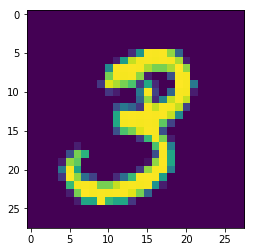

In [64]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
data = mnist.train.images

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
#plot = plt.imshow(full_data_x[1].reshape(28,28)) # This is what the image looks like

from scipy.ndimage import interpolation
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)
plt.imshow(data[1].reshape(28,28)) # This is what the image looks like
deskewed_data = deskewAll(data)

The above cell shows the data before deskewing and the below one shows the data after deskewing.

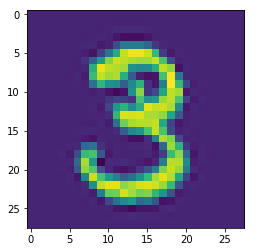

In [65]:
plt.imshow(deskewed_data[1].reshape(28,28)) # This is what the image looks like after deskewing

In [70]:
""" K-Means.
Implement K-Means algorithm with TensorFlow, and apply it to classify
handwritten digit images. This example is using the MNIST database of
handwritten digits as training samples (http://yann.lecun.com/exdb/mnist/).
Note: This example requires TensorFlow v1.1.0 or over.
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""

from __future__ import print_function

import numpy as np
import tensorflow as tf
from tensorflow.contrib.factorization import KMeans

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Import MNIST data
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
#data = mnist.train.images
def kmeans(data,test_x,test_y):
    # Parameters
    num_steps = 100 
    batch_size = 1024 
    k = 50 
    num_classes = 10 
    num_features = 784 

    #Input 
    X = tf.placeholder(tf.float32, shape=[None, num_features])
    Y = tf.placeholder(tf.float32, shape=[None, num_classes])

    # K-Means Parameters
    kmeans = KMeans(inputs=X, num_clusters=k, distance_metric='cosine',
                    use_mini_batch=True)

    # Build KMeans graph
    training_graph = kmeans.training_graph()

    if len(training_graph) > 6: 
        (all_scores, cluster_idx, scores, cluster_centers_initialized,
         cluster_centers_var, init_op, train_op) = training_graph
    else:
        (all_scores, cluster_idx, scores, cluster_centers_initialized,
         init_op, train_op) = training_graph

    cluster_idx = cluster_idx[0] # fix for cluster_idx being a tuple
    avg_distance = tf.reduce_mean(scores)

    init_vars = tf.global_variables_initializer()

    # Start TensorFlow session
    sess = tf.Session()

    # Run the initializer
    sess.run(init_vars, feed_dict={X: data})
    sess.run(init_op, feed_dict={X: data})

    # Training
    for i in range(1, num_steps + 1):
        _, d, idx = sess.run([train_op, avg_distance, cluster_idx],
                             feed_dict={X: data})
        if i % 10 == 0 or i == 1:
            print("Step %i, Avg Distance: %f" % (i, d))

    # Assign a label to each centroid
    # Count total number of labels per centroid, using the label of each training
    # sample to their closest centroid (given by 'idx')
    counts = np.zeros(shape=(k, num_classes))
    for i in range(len(idx)):
        counts[idx[i]] += mnist.train.labels[i]
    # Assign the most frequent label to the centroid
    labels_map = [np.argmax(c) for c in counts]
    labels_map = tf.convert_to_tensor(labels_map)

    # Evaluation ops
    # Lookup: centroid_id -> label
    cluster_label = tf.nn.embedding_lookup(labels_map, cluster_idx)
    # Compute accuracy
    correct_prediction = tf.equal(cluster_label, tf.cast(tf.argmax(Y, 1), tf.int32))
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Test Model
    #test_x, test_y = mnist.test.images, mnist.test.labels
    print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: test_x, Y: test_y}))

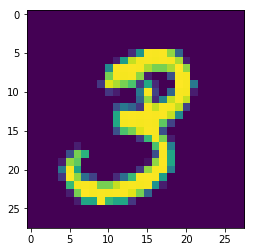

In [71]:
plt.imshow(data[1].reshape(28,28)) # This is what the image looks like
test_x, test_y = mnist.test.images, mnist.test.labels

In [72]:
kmeans(data,test_x,test_y)

Step 1, Avg Distance: 0.314557
Step 10, Avg Distance: 0.198182
Step 20, Avg Distance: 0.196513
Step 30, Avg Distance: 0.195821
Step 40, Avg Distance: 0.195415
Step 50, Avg Distance: 0.195135
Step 60, Avg Distance: 0.194927
Step 70, Avg Distance: 0.194766
Step 80, Avg Distance: 0.194634
Step 90, Avg Distance: 0.194525
Step 100, Avg Distance: 0.194433
Test Accuracy: 0.8106


In [73]:
deskewed_data = deskewAll(data)
deskewed_test = deskewAll(test_x)
kmeans(deskewed_data,deskewed_test,test_y)

Step 1, Avg Distance: 0.240252
Step 10, Avg Distance: 0.150108
Step 20, Avg Distance: 0.148725
Step 30, Avg Distance: 0.148210
Step 40, Avg Distance: 0.147925
Step 50, Avg Distance: 0.147734
Step 60, Avg Distance: 0.147597
Step 70, Avg Distance: 0.147492
Step 80, Avg Distance: 0.147407
Step 90, Avg Distance: 0.147337
Step 100, Avg Distance: 0.147278
Test Accuracy: 0.7456


In [81]:
"""
Simple logistic regression model to solve OCR task 
with MNIST in TensorFlow
MNIST dataset: yann.lecun.com/exdb/mnist/
"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import time

# Define paramaters for the model
learning_rate = 0.01
batch_size = 128
n_epochs = 10
#DROPOUT = 0.75

# Step 1: Read in data
# using TF Learn's built in function to load MNIST data to the folder MNIST_data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)


# Step 2: create placeholders for features and labels
# each image in the MNIST data is of shape 28*28 = 784
# therefore, each image is represented with a 1x784 tensor
# there are 10 classes for each image, corresponding to digits 0 - 9. 
# each lable is one hot vector.
X = tf.placeholder(tf.float32, [batch_size, 784], name='X_placeholder') 
Y = tf.placeholder(tf.int32, [batch_size, 10], name='Y_placeholder')

#dropout = tf.placeholder(tf.float32, name='dropout') #added placeholder for dropout

# Step 3: create weights and bias
# w is initialized to random variables with mean of 0, stddev of 0.01
# b is initialized to 0
# shape of w depends on the dimension of X and Y so that Y = tf.matmul(X, w)
# shape of b depends on Y
w = tf.Variable(tf.random_normal(shape=[784, 10], stddev=0.01), name='weights')
b = tf.Variable(tf.zeros([1, 10]), name="bias")

# Step 4: build model
# the model that returns the logits.
# this logits will be later passed through softmax layer
# to get the probability distribution of possible label of the image
# DO NOT DO SOFTMAX HERE
logits = tf.matmul(X, w) + b 
    # apply dropout
#logits = tf.nn.dropout(logits, dropout, name='logit_dropout')


# Step 5: define loss function
# use cross entropy loss of the real labels with the softmax of logits
# use the method:
# tf.nn.softmax_cross_entropy_with_logits(logits, Y)
# then use tf.reduce_mean to get the mean loss of the batch

entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y, name='loss')
loss = tf.reduce_mean(entropy) # computes the mean over all the examples in the batch

# Step 6: define training op
# using gradient descent to minimize loss
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.Session() as sess:
    writer = tf.summary.FileWriter('./graphs/logistic_reg', sess.graph) # to visualize using TensorBoard
    start_time = time.time()
    sess.run(tf.global_variables_initializer())	
    n_batches = int(mnist.train.num_examples/batch_size)
    for i in range(n_epochs): # train the model n_epochs times
        total_loss = 0

        for _ in range(n_batches):
            X_batch, Y_batch = mnist.train.next_batch(batch_size)
            X_batch = deskewAll(X_batch)
            _, loss_batch = sess.run([optimizer, loss], feed_dict={X: X_batch, Y:Y_batch})
            total_loss += loss_batch
        print('Average loss epoch {0}: {1}'.format(i, total_loss/n_batches))

    print('Total time: {0} seconds'.format(time.time() - start_time))
    print('Optimization Finished!') # should be around 0.35 after 25 epochs

    # test the model
    n_batches = int(mnist.test.num_examples/batch_size)
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = mnist.test.next_batch(batch_size)
        X_batch = deskewAll(X_batch)
        _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict={X: X_batch, Y:Y_batch})
        preds = tf.nn.softmax(logits_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32)) # need numpy.count_nonzero(boolarr) :(
        total_correct_preds += sess.run(accuracy)

    print('Accuracy {0}'.format(total_correct_preds/mnist.test.num_examples))
    writer.close()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Average loss epoch 0: 0.23488830577903416
Average loss epoch 1: 0.17548192600721801
Average loss epoch 2: 0.16896061236277604
Average loss epoch 3: 0.1634677822217519
Average loss epoch 4: 0.16235141897691296
Average loss epoch 5: 0.15839735227517593
Average loss epoch 6: 0.15477754628515883
Average loss epoch 7: 0.1537764998487173
Average loss epoch 8: 0.15405338552795647
Average loss epoch 9: 0.15064912488671034
Total time: 244.29588913917542 seconds
Optimization Finished!
Accuracy 0.9509


Just running code from Q3 with more epochs easily gets the 98% accuracy required for the question as we can see below.

In [1]:
""" Using convolutional net on MNIST dataset of handwritten digit
(http://yann.lecun.com/exdb/mnist/)
"""
from __future__ import print_function
from __future__ import division
from __future__ import print_function

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import time

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

#import utils

N_CLASSES = 10

# Step 1: Read in data
# using TF Learn's built in function to load MNIST data to the folder data/mnist
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)


# Step 2: Define paramaters for the model
LEARNING_RATE = 0.001
BATCH_SIZE = 128
SKIP_STEP = 100
DROPOUT = 0.75
N_EPOCHS = 20

# Step 3: create placeholders for features and labels
# each image in the MNIST data is of shape 28*28 = 784
# therefore, each image is represented with a 1x784 tensor
# We'll be doing dropout for hidden layer so we'll need a placeholder
# for the dropout probability too
# Use None for shape so we can change the batch_size once we've built the graph
with tf.name_scope('data'):
    X = tf.placeholder(tf.float32, [None, 784], name="X_placeholder")
    Y = tf.placeholder(tf.float32, [None, 10], name="Y_placeholder")

dropout = tf.placeholder(tf.float32, name='dropout')

# Step 4 + 5: create weights + do inference
# the model is conv -> relu -> pool -> conv -> relu -> pool -> fully connected -> softmax

global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

#utils.make_dir('checkpoints')
#utils.make_dir('checkpoints/convnet_mnist')

with tf.variable_scope('conv1') as scope:
    # first, reshape the image to [BATCH_SIZE, 28, 28, 1] to make it work with tf.nn.conv2d
    # use the dynamic dimension -1
    images = tf.reshape(X, shape=[-1, 28, 28, 1])

    # TO DO

    # create kernel variable of dimension [5, 5, 1, 32]
    # use tf.truncated_normal_initializer()

    kernel = tf.get_variable('kernel', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer())

    # create biases variable of dimension [32]
    # use tf.constant_initializer(0.0)
    biases = tf.get_variable('biases', [32], initializer=tf.constant_initializer(0.0))
    # TO DO

    # apply tf.nn.conv2d. strides [1, 1, 1, 1], padding is 'SAME'

    conv = tf.nn.conv2d(images, kernel, strides=[1, 1, 1, 1], padding='SAME')

    # apply relu on the sum of convolution output and biases

    conv1 = tf.nn.relu(conv + biases, name=scope.name)

    # output is of dimension BATCH_SIZE x 28 x 28 x 32

with tf.variable_scope('pool1') as scope:
# apply max pool with ksize [1, 2, 2, 1], and strides [1, 2, 2, 1], padding 'SAME'

    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# output is of dimension BATCH_SIZE x 14 x 14 x 32

with tf.variable_scope('conv2') as scope:
    # similar to conv1, except kernel now is of the size 5 x 5 x 32 x 64
    kernel = tf.get_variable('kernels', [5, 5, 32, 64],
                             initializer=tf.truncated_normal_initializer())
    biases = tf.get_variable('biases', [64],
                             initializer=tf.random_normal_initializer())
    conv = tf.nn.conv2d(pool1, kernel, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv + biases, name=scope.name)

    # output is of dimension BATCH_SIZE x 14 x 14 x 64

with tf.variable_scope('pool2') as scope:
    # similar to pool1
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                           padding='SAME')

    # output is of dimension BATCH_SIZE x 7 x 7 x 64

with tf.variable_scope('fc') as scope:
    # use weight of dimension 7 * 7 * 64 x 1024
    input_features = 7 * 7 * 64

    # create weights and biases

    w = tf.get_variable('weights', [input_features, 1024], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('biases', [1024], initializer=tf.random_normal_initializer())

    # reshape pool2 to 2 dimensional
    pool2 = tf.reshape(pool2, [-1, input_features])

    # apply relu on matmul of pool2 and w + b
    fc = tf.nn.relu(tf.matmul(pool2, w) + b, name='relu')

    # TO DO

    # apply dropout
    fc = tf.nn.dropout(fc, dropout, name='relu_dropout')

with tf.variable_scope('softmax_linear') as scope:
# this you should know. get logits without softmax
# you need to create weights and biases

    w = tf.get_variable('weights', [1024, 10], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('biases', [10], initializer=tf.random_normal_initializer())

# Step 6: define loss function
# use softmax cross entropy with logits as the loss function
# compute mean cross entropy, softmax is applied internally
    logits = tf.matmul(fc, w) + b

with tf.name_scope('loss'):
# you should know how to do this too

    entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)
    loss = tf.reduce_mean(entropy, name='loss')

# Step 7: define training op
# using gradient descent with learning rate of LEARNING_RATE to minimize cost
# don't forgot to pass in global_step

    optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss, global_step=global_step)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    # to visualize using TensorBoard
    #writer = tf.summary.FileWriter('./my_graph/mnist', sess.graph)
    ##### You have to create folders to store checkpoints
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/convnet_mnist/checkpoint'))
    # if that checkpoint exists, restore from checkpoint
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

    initial_step = global_step.eval()

    start_time = time.time()
    n_batches = int(mnist.train.num_examples / BATCH_SIZE)

    total_loss = 0.0
    for index in range(initial_step, n_batches * N_EPOCHS):  # train the model n_epochs times
        X_batch, Y_batch = mnist.train.next_batch(BATCH_SIZE)
        _, loss_batch = sess.run([optimizer, loss],
                                 feed_dict={X: X_batch, Y: Y_batch, dropout: DROPOUT})
        total_loss += loss_batch
        if (index + 1) % SKIP_STEP == 0:
            print('Average loss at step {}: {:5.1f}'.format(index + 1, total_loss / SKIP_STEP))
            total_loss = 0.0
            saver.save(sess, 'checkpoints/convnet_mnist/mnist-convnet', index)

    print("Optimization Finished!")  # should be around 0.35 after 25 epochs
    print("Total time: {0} seconds".format(time.time() - start_time))

    # test the model
    n_batches = int(mnist.test.num_examples / BATCH_SIZE)
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = mnist.test.next_batch(BATCH_SIZE)
        _, loss_batch, logits_batch = sess.run([optimizer, loss, logits],
                                               feed_dict={X: X_batch, Y: Y_batch, dropout: DROPOUT})
        preds = tf.nn.softmax(logits_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
        total_correct_preds += sess.run(accuracy)

    print("Accuracy {0}".format(total_correct_preds / mnist.test.num_examples))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from checkpoints/convnet_mnist/mnist-convnet-2139
Average loss at step 21

Average loss at step 3840:  33.5
Average loss at step 3850:  37.8
Average loss at step 3860:  21.0
Average loss at step 3870:  29.0
Average loss at step 3880:  28.7
Average loss at step 3890:  15.1
Average loss at step 3900:  19.5
Average loss at step 3910:  17.4
Average loss at step 3920:  25.4
Average loss at step 3930:  21.5
Average loss at step 3940:  16.5
Average loss at step 3950:  29.2
Average loss at step 3960:  17.5
Average loss at step 3970:   7.5
Average loss at step 3980:  16.8
Average loss at step 3990:  35.0
Average loss at step 4000:  26.3
Average loss at step 4010:  20.9
Average loss at step 4020:  35.2
Average loss at step 4030:  19.4
Average loss at step 4040:  32.8
Average loss at step 4050:  25.1
Average loss at step 4060:  12.5
Average loss at step 4070:  29.4
Average loss at step 4080:  11.9
Average loss at step 4090:  25.3
Average loss at step 4100:  28.1
Average loss at step 4110:  20.2
Average loss at step 4120:  16.6
Average loss at step 4130:  26.8
Average lo

Average loss at step 6330:  10.6
Average loss at step 6340:   9.4
Average loss at step 6350:  14.2
Average loss at step 6360:  11.1
Average loss at step 6370:   7.6
Average loss at step 6380:   7.9
Average loss at step 6390:   8.9
Average loss at step 6400:  13.5
Average loss at step 6410:  11.9
Average loss at step 6420:  12.0
Average loss at step 6430:  12.7
Average loss at step 6440:   9.6
Average loss at step 6450:  13.3
Average loss at step 6460:   3.9
Average loss at step 6470:  11.4
Average loss at step 6480:  10.4
Average loss at step 6490:  14.4
Average loss at step 6500:  15.3
Average loss at step 6510:   5.1
Average loss at step 6520:  15.3
Average loss at step 6530:  13.7
Average loss at step 6540:  12.5
Average loss at step 6550:   8.8
Average loss at step 6560:   6.7
Average loss at step 6570:  11.0
Average loss at step 6580:  15.7
Average loss at step 6590:  10.6
Average loss at step 6600:  15.1
Average loss at step 6610:  11.1
Average loss at step 6620:   6.5
Average lo